In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
# import seaborn as sns

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 5 #this defines the criterion which we use to filter authors
MAX_CAREER_LENGTH_COHORT = 15    # this defines how long we follow each cohort
END_YEAR = 2015


## Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

### Read Gender details

In [40]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')
gender.rename(columns={'name':'author'}, inplace=True)

In [41]:
print(gender.shape)
gender = gender.drop_duplicates()
print(gender.shape)
# Gender file is full of duplicates. As we use the author's name as ID, duplicate entries provide no extra info

(1704919, 2)
(1704919, 2)


In [42]:
gender_stats = gender.groupby('gender').size().to_frame()
gender_stats.columns = ['count']
gender_total = gender_stats['count'].sum()
gender_stats['percentage'] = gender_stats['count'].apply(lambda x: x/gender_total*100)
print("Number of unique authors: ", gender['author'].nunique())
gender_stats.head()

Number of unique authors:  1704919


,count,percentage
gender,,
f,255793,15.003235
m,796975,46.745623
none,652151,38.251143


### Read authors with start and end year details

In [43]:
# Different files exists depending upon their career length

#authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print("author unique names  - ", authorStartEndCareerData['author'].nunique())
authorStartEndCareerData.head()

authorStartEndCareerData before filtering -  503859
authorStartEndCareerData after filtering -  503859
author unique names  -  503859


,author,start_year,end_year,num_pub,career_length
0,'maseka lesaoana,2001,2015,2,15
1,a aart blokhuis,1992,2005,2,14
2,a min tjoa,1979,2017,191,39
3,a-imam al-sammak,1992,2006,3,15
4,a-long jin,2011,2016,9,6


### Merge credible authors and their gender information

In [44]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
authorStartEndCareerData.rename(columns={'num_pub':'total_num_pub'}, inplace=True)
# print("authorStartEndCareerData with duplicates: ", authorStartEndCareerData.shape[0])
# authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: ", authorStartEndCareerData.shape[0])

authorStartEndCareerData.head()

authorStartEndCareerData no duplicates:  503859


,author,start_year,end_year,total_num_pub,career_length,gender
0,'maseka lesaoana,2001,2015,2,15,none
1,a aart blokhuis,1992,2005,2,14,none
2,a min tjoa,1979,2017,191,39,none
3,a-imam al-sammak,1992,2006,3,15,m
4,a-long jin,2011,2016,9,6,none


In [45]:
#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()

### Read Publication data

In [46]:
authorPublicationData = pd.read_csv('./data/author_publications_2017_asiansAsNone.txt')
print('authorPublicationData before filtering - ',authorPublicationData.shape[0])
authorPublicationData = authorPublicationData[authorPublicationData["year"] >= 1970]
print('authorPublicationData after filtering - ',authorPublicationData.shape[0])

authorPublicationData = authorPublicationData.groupby(['year','author']).count().reset_index()
authorPublicationData.rename(columns={'pub_id':'num_pub'}, inplace=True)

print(np.unique(authorStartEndCareerData["start_year"]))

authorPublicationData.head()

authorPublicationData before filtering -  9471668
authorPublicationData after filtering -  9462275
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]


,year,author,num_pub
0,1970,a. a. afifi,1
1,1970,a. armenti,1
2,1970,a. c. mckellar,1
3,1970,a. c. williams,1
4,1970,a. colin day,1


### Merge Publications with credible authors and their gender information

In [47]:
authorPublicationData = pd.merge(authorPublicationData, authorStartEndCareerData, how="inner", on=["author"])


print("authorPublicationData before filtering: ", authorPublicationData.shape[0])
authorPublicationData = authorPublicationData.dropna(how='any')
print("authorPublicationData after filtering: ", authorPublicationData.shape[0])

print("authorPublicationData with duplicates: ", authorPublicationData.shape[0])
authorPublicationData = authorPublicationData.drop_duplicates()
print("authorPublicationData no duplicates: ", authorPublicationData.shape[0])

#print(authorPublicationData.head(n=2))
print(authorPublicationData['author'].nunique())
#print(authorPublicationData.shape[0])


#print(authorPublicationData[authorPublicationData.author=="a min tjoa"])
authorPublicationData.head()

authorPublicationData before filtering:  3246017
authorPublicationData after filtering:  3246017
authorPublicationData with duplicates:  3246017
authorPublicationData no duplicates:  3246017
503859


,year,author,num_pub,start_year,end_year,total_num_pub,career_length,gender
0,1970,a. moore,1,1970,2012,2,43,m
1,2012,a. moore,1,1970,2012,2,43,m
2,1970,a. trew,1,1970,2008,2,39,m
3,2008,a. trew,1,1970,2008,2,39,m
4,1970,adeline paiement,1,1970,2017,11,48,f


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


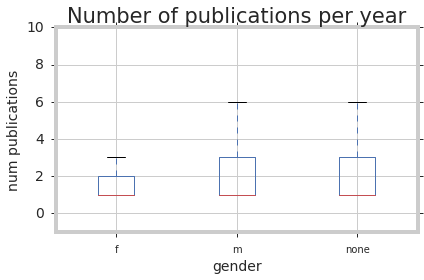

In [48]:
pl = authorPublicationData.boxplot(column='num_pub', by='gender', showfliers=False)
plt.title("Number of publications per year")
plt.suptitle("")
pl.set_xlabel('gender')
pl.set_ylabel('num publications')
pl.set_ylim([-1,10])
plt.show()

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


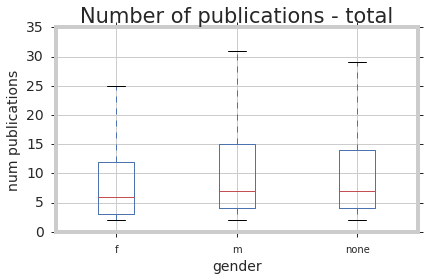

In [ ]:
ax = authorStartEndCareerData.boxplot(column='total_num_pub', by='gender', showfliers=False)
plt.title("Number of publications - total")
plt.suptitle("")
ax.set_xlabel('gender')
ax.set_ylabel('num publications')
# fig.set_tight_layout(False)
plt.show()

### Test Data ???

In [ ]:
print(authorPublicationData.head(n=1))

groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))

groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))



   year    author  num_pub  start_year  end_year  total_num_pub  \
0  1970  a. moore        1        1970      2012              2   

   career_length gender  
0             43      m  
        year            author  num_pub  start_year  end_year  total_num_pub  \
284566  1987  donatella sciuto        1        1987      2016            349   
284567  1988  donatella sciuto        2        1987      2016            349   
284568  1989  donatella sciuto        1        1987      2016            349   

        career_length gender  
284566             30      f  
284567             30      f  
284568             30      f  


In [ ]:

print(np.unique(groupByYearData["year"]))
print(np.unique(groupByYearData["career_length"]))

# Cohort Analysis on all authors for 15 years

In [ ]:
years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

### Select Cohorts based on Start Years

In [ ]:
cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]
#cohort_start_years = [1970, 1974, 1984, 1994, 1998]



### Cohort Analysis (Num Pub)

In [ ]:
# from importlib import reload
# reload(plot)
print(groupByYearData.head())

In [ ]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications")  

### Cohort Analysis (Cum Num Pub)

In [ ]:
# from importlib import reload
# reload(plot)
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cumulative Publications")  


### Cumulative Distribution of selected Cohorts for selected Career Ages

how do the distributions differ? 

In [ ]:
cohort_start_years = [1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]

cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, CAREER_LENGTH, 'num_pub')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_pub', 'Number of Publications')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_pub', 'Number of Publications')
# plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_pub', 'Number of Publications')
# plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_pub', 'Number of Publications')



### Regression Analysis of mean productivity on Inequality for all authors for 15 years

- There is no relation at all - Reg. coefficient is 0

In [ ]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)


In [ ]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

Regression???
outcome variable: inequality of each cohort an each time interval (2 years)
Indepent variable: number of publications that the cohort produced during the time interval

Question: are more inequal groups, more productive?  

In [ ]:
#groupByYearData = authorPublicationData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_pub')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', cohort_start_years, CAREER_LENGTH, 'Publications Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', cohort_start_years, CAREER_LENGTH, 'Cumulative Publications Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 15 years

In [ ]:
#groupByYearData = authorPublicationData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_pub')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', cohort_start_years, CAREER_LENGTH, 'Publications Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', cohort_start_years, CAREER_LENGTH, 'Cumulative Publications Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, CAREER_LENGTH)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, CAREER_LENGTH)